# A deeper dive into `AutoEmulate`

## Why `AutoEmulate`

Simulations of real-world physical, chemical or biological processes can be complex and computationally expensive, and will often need high-performance computing resources and a lot of time to run. This becomes a problem when simulations need to be run thousands or tens of thousands of times to do uncertainty quantification or sensitivity analysis. It's also a problem when a simulation needs to run fast enough to be useful in real-world applications, such as digital twins. 

Emulator models are drop-in replacements for complex simulations, and can be orders of magnitude faster. Any model could in principle be an emulator, from a simple linear regression to Gaussian Processes to Neural Networks. Evaluating all these models requires time and machine learning expertise. `AutoEmulate` is designed to automate the process of finding a good emulator model for a simulation. 

In the background, `AutoEmulate` does input processing, cross-validation, hyperparameter optimization and model selection. It's different from typical AutoML packages, as the choice of models and hyperparameter search spaces is optimised for typical emulation problems. Over time, we expect the package to further adapt to the emulation needs of the community.

## Workflow

A typical workflow will involve a) generating data from a simulation, b) running `AutoEmulate` c) evaluating results and d) saving and loading the emulator.

In [1]:
import numpy as np
import pandas as pd

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.projectile import simulator, simulator_multioutput
from autoemulate.compare import AutoEmulate

### 1) Experimental Design (Sampling)

Let's first generate a set of inputs/outputs.  We'll again use a projectil motion simulator (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). It takes two inputs, the drag coefficient (on a log scale) and the velocity and outputs the distance the projectile travelled. We sample 200 sets of inputs `X` using a Latin Hypercube and run the simulator for those inputs to get a vector of outputs `y`. 

In [2]:
seed = 42
np.random.seed(seed)

lhd = LatinHypercube([(-5., 1.), (0., 1000.)])
X = lhd.sample(200)
y = np.array([simulator(x) for x in X])

print(f"shapes: input X: {X.shape}, output y: {y.shape}\n")

shapes: input X: (200, 2), output y: (200,)



### 2) Emulation
The simplest way to test different emulators is to run `AutoEmulate` with default parameters, providing only inputs `X` and outputs `y`. What happens in the background is that the inputs will be **standardised** (`scale`=True), after which various models are fitted and evaluated using 5-fold **cross-validation**.

In [3]:
em = AutoEmulate()
em.setup(X, y)
em.compare()

autoemulate - Cross-validating SecondOrderPolynomial...
autoemulate - Parameters: {'degree': 2}
autoemulate - Cross-validating RBF...
autoemulate - Parameters: {'degree': 1, 'epsilon': 1.0, 'kernel': 'thin_plate_spline', 'smoothing': 0.0}
autoemulate - Cross-validating RandomForest...
autoemulate - Parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': False, 'random_state': None}
autoemulate - Cross-validating GradientBoosting...
autoemulate - Parameters: {'ccp_alpha': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0}
autoemulate - Cross-validating GaussianProcessSk...
autoemulate - Parameters: {'alpha': 1e-10, 'copy_X_train': True, 'kernel__length_scale': 1.0, 'kerne

Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianProcessSk())])

### 3) Evaluation

We can print the results to see that several models have a high $R^2$ and root mean squared error, suggesting a good fit. These metrics are the average metric on the test data across cv-folds.

In [4]:
em.print_results()

Average scores across all models:
                   model        r2         rmse
0      GaussianProcessSk  0.999659   127.340729
1                    RBF  0.996021   454.018482
2           RandomForest  0.955690  1618.997797
3       GradientBoosting  0.955341  1348.984777
4                XGBoost  0.912841  2136.656089
5  SupportVectorMachines  0.842269  2991.954514
6  SecondOrderPolynomial  0.686951  4161.733648
7            NeuralNetSk -0.133860  8656.837598
8         NeuralNetTorch -0.218323  8502.448828


We can also look at each of the cv-folds for a specific model, like Gaussian Processes.

In [5]:
em.print_results(model="GaussianProcessSk")

Scores for GaussianProcessSk across all folds:
metric        r2        rmse
fold                        
0       0.999643   99.280876
1       0.999149  410.480184
2       0.999999    6.776826
3       0.999757   60.770100
4       0.999749   59.395657


Next, we can plot predicted vs true values (`plot_type="actual_vs_predicted"`). If the simulation has multiple outputs, the default is to plot the first output (`output_index=0`), but this can be changed. by default, `plot_results()` plots the best fitting cv-fold for each model.

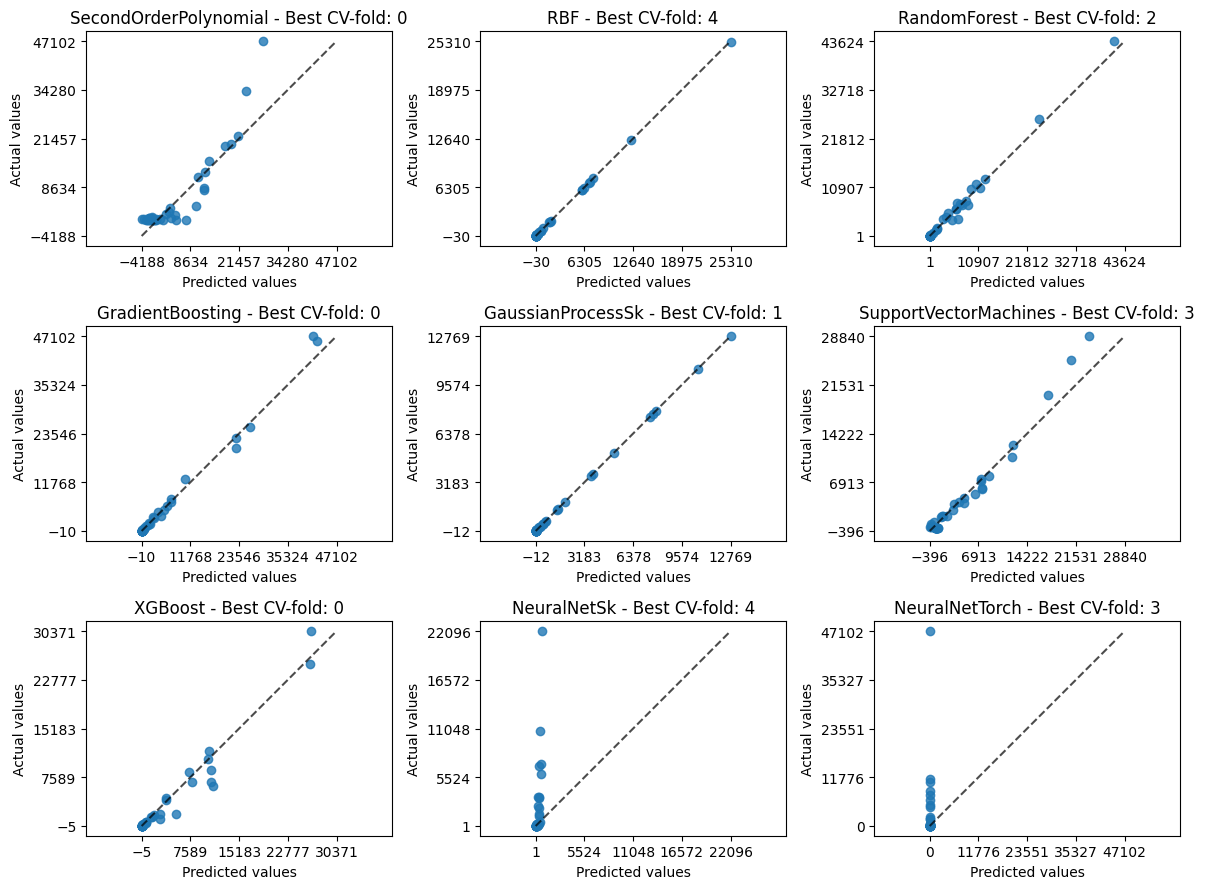

In [6]:
em.plot_results()

We can alternatively plot a residuals plot to inspect how residuals vary with predictions.

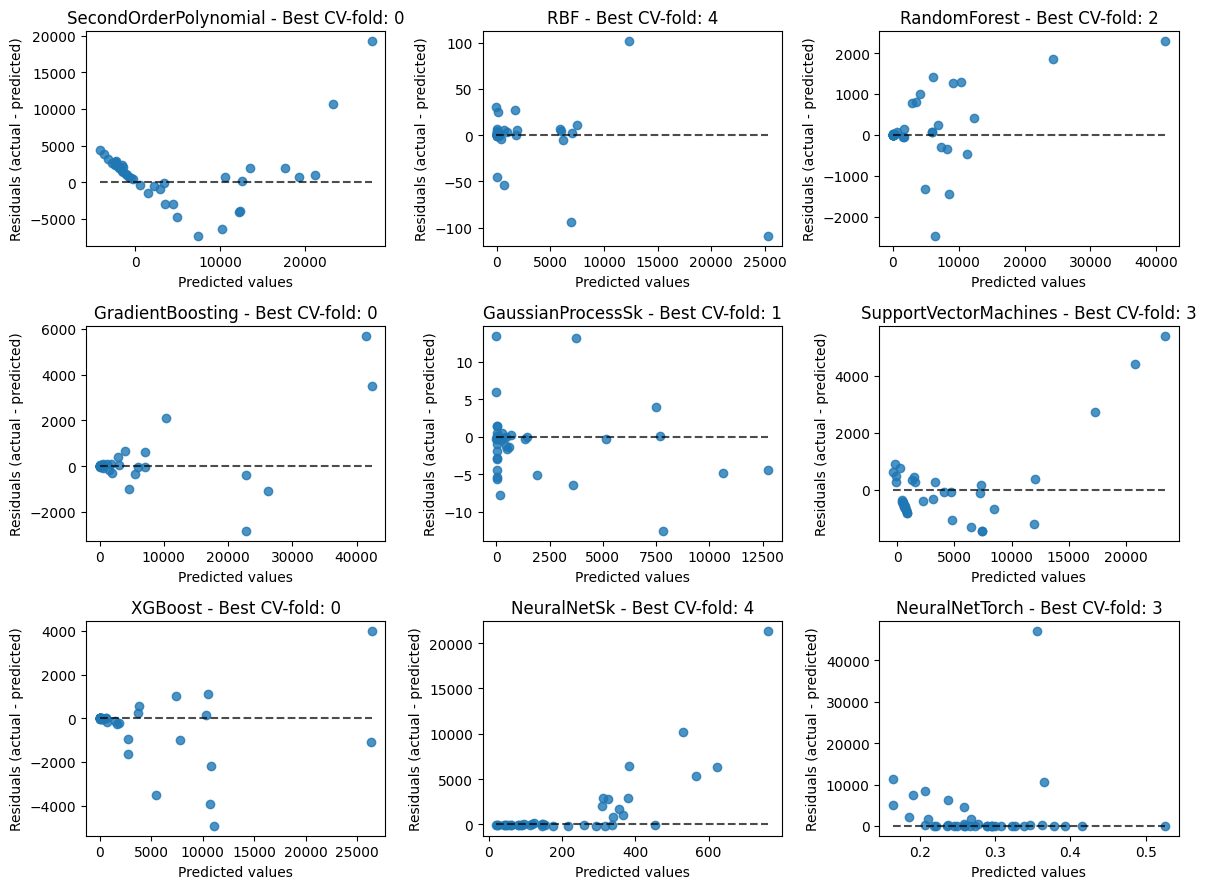

In [7]:
em.plot_results(plot_type="residual_vs_predicted")

To inspect specific models more closely, we can plot each fold for a given model.

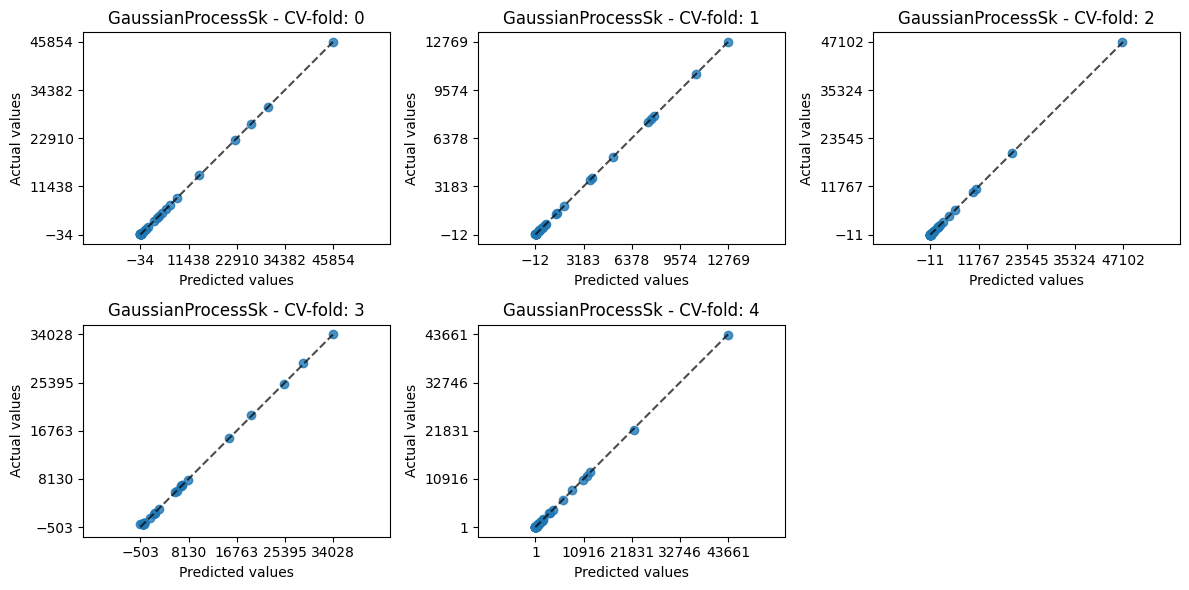

In [8]:
em.plot_results(model='GaussianProcessSk')

### 4) Saving / Loading



First, we'll get the best model.

In [9]:
best_model = em.get_model(rank=1)
best_model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('model', GaussianProcessSk())],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': GaussianProcessSk(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__alpha': 1e-10,
 'model__copy_X_train': True,
 'model__kernel__length_scale': 1.0,
 'model__kernel__length_scale_bounds': (1e-05, 100000.0),
 'model__kernel': RBF(length_scale=1),
 'model__n_restarts_optimizer': 20,
 'model__normalize_y': True,
 'model__optimizer': 'fmin_l_bfgs_b',
 'model__random_state': None}

In [10]:
em.save_model(best_model, "best_model.pkl")

In [11]:
best_model_loaded = em.load_model("best_model.pkl")
best_model_loaded

Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianProcessSk())])

## Hyperparameter search

Although we chose default model parameter that should work well in a range of scenarios, hyperparameter optimisation is usually helpful in finding a good emulator model. The trade-off is that it can be computationally expensive. For each model, we've pre-defined a search space for hyperparameters. When setting up `AutoEmulate` with `param_search=True`, we default to a random search with `param_search_iters = 20` iterations. The alternative is `param_search_method = "bayes"` which uses a Bayesian optimisation method (see [here](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) for details). 

Both random and Bayesian search run cross-validation (default: 5-fold) for each parameter combination, and compare the average cv-results to find the best hyperparameters. To speed this up, we can parallelise the process with `n_jobs`. We use `n_jobs=-2` to use all available cores except for one.

In [12]:
em = AutoEmulate()
em.setup(X, y, param_search=True, param_search_type="random", param_search_iters=20, n_jobs=-2)
em.compare()

autoemulate - Performing grid search for SecondOrderPolynomial...
autoemulate - Best parameters for SecondOrderPolynomial: {}
autoemulate - Cross-validating SecondOrderPolynomial...
autoemulate - Parameters: {'degree': 2}
autoemulate - Performing grid search for RBF...
autoemulate - Best parameters for RBF: {'model__degree': 2, 'model__kernel': 'quintic', 'model__smoothing': 0.20747022183931518}
autoemulate - Cross-validating RBF...
autoemulate - Parameters: {'degree': 2, 'epsilon': 1.0, 'kernel': 'quintic', 'smoothing': 0.20747022183931518}
autoemulate - Performing grid search for RandomForest...
autoemulate - Best parameters for RandomForest: {'model__bootstrap': False, 'model__max_features': None, 'model__max_samples': None, 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 460, 'model__oob_score': True}
autoemulate - Cross-validating RandomForest...
autoemulate - Parameters: {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': None, 'max

In [13]:
em.print_results()

Test score for each model:
                   model        r2         rmse
0      GaussianProcessSk  0.999992    25.658636
1                    RBF  0.997355   462.059373
2            NeuralNetSk  0.996914   499.080184
3       GradientBoosting  0.983182  1165.174522
4  SupportVectorMachines  0.951933  1969.805883
5           RandomForest  0.845578  3530.648926
6  SecondOrderPolynomial  0.799761  4020.445999
7                XGBoost  0.057884  8720.710774
8         NeuralNetTorch -0.165523  9699.743164


## Multioutput simulations

All models run with multi-output data as well. Some models naively support multiple outputs. For models that don't, `AutoEmulate` fits the model to each output separately under the hood. To check which models run separately for each output, we can check a model and see whether the pipeline includes a `MultiOutputRegressor` step.

In [14]:
em = AutoEmulate()
em.setup(X, y)
print(em.models[5]) # print the 5th model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SupportVectorMachines())])


## Data pre-processing

### Standardisation
By default, `AutoEmulate` standardised inputs (`scale=True`) to have zero mean and unit variance (`scaler=StandardScaler()`). [Other normalisers](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) can be used, or the inputs can be left unscaled (`scale=False`). Also, some models, like Gaussian Processes tend to work better when outputs are standardised as well. Checking the parameters of a model with `model.get_params()` will show whether the model standardises outputs.

### Dimension reduction
For inputs with lots of variables, we can add a dimension reduction step to each model using `reduce_dim=True`. Be default, this uses PCA from scikit-learn, but [other dimension reduction methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) can be used.